In [15]:
import pandas as pd
from PIL import Image
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Average
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import mode

In [16]:
## Process training images
# Path to the CSV file
csv_path = "/kaggle/input/multivariate-analysis-2024-1-final-project/ma_2024_1/train.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_path)

# Define the base path for the Kaggle directory
base_path = "/kaggle/input/multivariate-analysis-2024-1-final-project/ma_2024_1/train/"

# Prepend the base path to each file path in the DataFrame
df['file_path'] = base_path + df['file_path'].astype(str)

# Define function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(50, 50)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0
    mean, std = cv2.meanStdDev(image)
    mean = mean.flatten()
    std = std.flatten()
    
    # Prevent division by zero by setting zero std deviations to a small value
    std[std == 0] = 1
    
    normalized_image = (image - mean) / std
    return normalized_image

# Create lists to hold images and labels
images = []
labels = []

# Loop over the rows of the dataframe and load images and labels
for index, row in tqdm(df.iterrows()):
    image_path = os.path.join(base_path, row['file_path'])
    label = row['label']
    image = load_and_preprocess_image(image_path)

    images.append(image)
    labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Display the shape of the loaded data
print('Images shape:', images.shape)
print('Labels shape:', labels.shape)

29737it [01:14, 400.41it/s]


Images shape: (29737, 50, 50, 3)
Labels shape: (29737,)


In [17]:
## Process testing images
# Path to the CSV file
csv_path = "/kaggle/input/multivariate-analysis-2024-1-final-project/ma_2024_1/test.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_path)

# Define the base path for the Kaggle directory
base_path = "/kaggle/input/multivariate-analysis-2024-1-final-project/ma_2024_1/"

# Prepend the base path to each file path in the dataFrame
df['file_path'] = base_path + df['file_path'].astype(str)

# Create lists to hold images
images_test = []

# Loop over the rows of the dataframe and load images and labels
for index, row in tqdm(df.iterrows()):
    image_path = os.path.join(base_path, row['file_path'])
    image = load_and_preprocess_image(image_path)
    images_test.append(image)

# Convert list to numpy array
images_test = np.array(images_test)

# Display the shape of the loaded data
print('Images shape:', images_test.shape)

22567it [00:57, 395.90it/s]


Images shape: (22567, 50, 50, 3)


In [18]:
# Construct model (Version 1)
model = Sequential()

# Add first convolution layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", input_shape=(50, 50, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Add second convolution layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Add third convolution layer
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Add fourth convolution layer
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Add flatten layer (convert feature into one-dimension vector)
model.add(Flatten())

# Construct the model
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=1000, activation="softmax"))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1000)           │       257,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,958,824 (7.47 MB)

 Trainable params: 1,957,864 (7.47 MB)

 Non-trainable params: 960 (3.75 KB)

In [19]:
# Construct model (Version 2 & 3)
model = Sequential()

# Add first convolution layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", input_shape=(50, 50, 3), activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Add second convolution layer
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Add third convolution layer
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Add fourth convolution layer
model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Add flatten layer (convert feature into one-dimension vector)
model.add(Flatten())

# Construct the model
model.add(Dense(units=1024, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=1024, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=1000, activation="softmax"))

# Print model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 50, 50, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1024)           │             

 Total params: 11,483,432 (43.81 MB)

 Trainable params: 11,481,512 (43.80 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [20]:
# Split the data into training and validation set
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.15, random_state=42)

# Create the data generator with augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.2, # 寬度最多會縮小到原本的20%
    height_shift_range=0.2, # 高度最多會縮小到原本的20%
    zoom_range=0.2, # 寬高最多會同時縮小到原本的20%
    horizontal_flip=False # 不要水平翻轉影像
)

# Fit the data generator on the training data
datagen.fit(x_train)

# Compile the model
lr = 1e-3
optimizer = Adam(learning_rate=lr)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Train the model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',  # 保存最佳模型的文件名
    monitor='val_accuracy',  # 根據驗證準確率判斷最佳模型
    save_best_only=True,  # 只保存最好的模型
    mode='max',  # 驗證準確率越高越好
    verbose=1  # 輸出保存信息
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # 監測驗證集資料損失
    factor=0.7,          # 將學習率减少為原来的70%
    patience=10,         # 如果驗證集資料在10個epoch内沒有下降，就降低學習率
    min_lr=1e-7,         # 學習率最小值為1e-7
    verbose=1            # 輸出學習率調整的過程
)

train_history = model.fit(x_train,y_train,epochs=200,batch_size=64,validation_data=(x_val, y_val),callbacks=[checkpoint,reduce_lr])

Epoch 1/5
  3/395 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.0000e+00 - loss: 8.1246 

W0000 00:00:1718812432.189117     227 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.0011 - loss: 7.0196

W0000 00:00:1718812470.795432     228 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718812472.497727     227 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.00134, saving model to best_model.keras


W0000 00:00:1718812477.240539     229 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


395/395 ━━━━━━━━━━━━━━━━━━━━ 72s 116ms/step - accuracy: 0.0011 - loss: 7.0193 - val_accuracy: 0.0013 - val_loss: 6.7884 - learning_rate: 0.0010
Epoch 2/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0032 - loss: 6.7210
Epoch 2: val_accuracy improved from 0.00134 to 0.00448, saving model to best_model.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.0032 - loss: 6.7208 - val_accuracy: 0.0045 - val_loss: 6.5873 - learning_rate: 0.0010
Epoch 3/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0089 - loss: 6.3096
Epoch 3: val_accuracy improved from 0.00448 to 0.00807, saving model to best_model.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.0089 - loss: 6.3094 - val_accuracy: 0.0081 - val_loss: 5.9890 - learning_rate: 0.0010
Epoch 4/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0121 - loss: 5.8928
Epoch 4: val_accuracy improved from 0.00807 to 0.01704, saving model to best_model.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - 

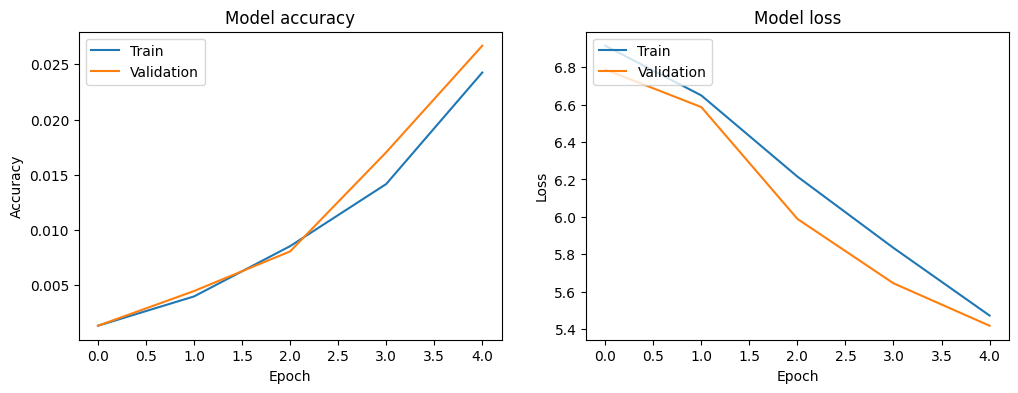

 19/706 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step

W0000 00:00:1718812562.159996     226 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


706/706 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


W0000 00:00:1718812567.551869     227 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [21]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# Predict the test set
prediction = model.predict(images_test)
prediction.shape
# Define the confidence threshold
confidence_threshold = 0.5

# Convert the predictions to class labels or -1 if below threshold
predicted_labels = []
for pred in prediction:
    max_confidence = np.max(pred)
    if max_confidence < confidence_threshold:
        predicted_labels.append(-1)
    else:
        predicted_labels.append(np.argmax(pred))

# Load the submission template
submission_file_path = '/kaggle/input/multivariate-analysis-2024-1-final-project/ma_2024_1/sample_submission.csv'
submission_df = pd.read_csv(submission_file_path)

# Replace the label column with final_predictions
submission_df['label'] = predicted_labels

# Save the updated submission file
output_file_path = 'final_submission.csv' 
submission_df.to_csv(output_file_path, index=False)

In [8]:
# Majority voting

# Load the trained models
model1 = tf.keras.models.load_model(
    '/kaggle/input/my-training-model/best_model_0616.keras'
)
model2 = tf.keras.models.load_model(
    '/kaggle/input/my-training-model/best_model_0617.keras'
)
model3 = tf.keras.models.load_model(
    '/kaggle/input/my-training-model/best_model_0618.keras'
)
model4 = tf.keras.models.load_model(
    '/kaggle/input/my-training-model/best_model_3.keras'
)
model5 = tf.keras.models.load_model(
    '/kaggle/input/my-training-model/best_model_2.keras'
)
model6 = tf.keras.models.load_model(
    '/kaggle/input/my-training-model/best_model.keras'
)

# Make predictions
pred1 = model1.predict(images_test) 
pred2 = model2.predict(images_test)
pred3 = model3.predict(images_test)
pred4 = model4.predict(images_test)
pred5 = model5.predict(images_test)
pred6 = model6.predict(images_test)

# Convert the predictions to class labels
pred1_classes = np.argmax(pred1, axis=1)
pred2_classes = np.argmax(pred2, axis=1)
pred3_classes = np.argmax(pred3, axis=1)
pred4_classes = np.argmax(pred4, axis=1)
pred5_classes = np.argmax(pred5, axis=1)
pred6_classes = np.argmax(pred5, axis=1)

# Stack predictions
preds = np.stack([pred1_classes, pred2_classes, pred3_classes,
                  pred4_classes, pred5_classes, pred6_classes], 
                 axis=1)

# Perform majority voting
final_preds, _ = mode(preds, axis=1)
final_preds = final_preds.flatten()

# Define a confidence threshold for low-confidence predictions
confidence_threshold = 0.5

# Calculate the maximum confidence for each prediction from each model
max_conf1 = np.max(pred1, axis=1)
max_conf2 = np.max(pred2, axis=1)
max_conf3 = np.max(pred3, axis=1)
max_conf4 = np.max(pred4, axis=1)
max_conf5 = np.max(pred5, axis=1)
max_conf6 = np.max(pred6, axis=1)

# Average confidence scores
average_confidence = (max_conf1 + max_conf2 + max_conf3 +
                      max_conf4 + max_conf5 + max_conf6 ) / 6

# Assign -1 to low-confidence predictions
final_preds_mv = np.where(average_confidence < confidence_threshold, -1, final_preds)

# Load the submission template
submission_file_path = '/kaggle/input/multivariate-analysis-2024-1-final-project/ma_2024_1/sample_submission.csv'
submission_df = pd.read_csv(submission_file_path)

# Replace the label column with final_predictions
submission_df['label'] = final_preds_mv

# Save the updated submission file
output_file_path = 'final_submission_en_majority.csv' 
submission_df.to_csv(output_file_path, index=False)

 19/706 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step

W0000 00:00:1718810676.962707     229 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


706/706 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


W0000 00:00:1718810682.190278     229 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 20/706 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step

W0000 00:00:1718810684.869341     227 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


706/706 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


W0000 00:00:1718810690.152330     227 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 19/706 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step

W0000 00:00:1718810692.843917     228 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


706/706 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


W0000 00:00:1718810698.171361     226 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 19/706 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step

W0000 00:00:1718810700.864117     228 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


706/706 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


W0000 00:00:1718810706.193911     229 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 22/706 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

W0000 00:00:1718810708.861978     227 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


706/706 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


W0000 00:00:1718810713.230923     227 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [7]:
# Average method

# Load the trained models
model1 = tf.keras.models.load_model(
    '/kaggle/input/my-training-model/best_model_0616.keras'
)
model2 = tf.keras.models.load_model(
    '/kaggle/input/my-training-model/best_model_0617.keras'
)
model3 = tf.keras.models.load_model(
    '/kaggle/input/my-training-model/best_model_0618.keras'
)
model4 = tf.keras.models.load_model(
    '/kaggle/input/my-training-model/best_model_3.keras'
)
model5 = tf.keras.models.load_model(
    '/kaggle/input/my-training-model/best_model_2.keras'
)
model6 = tf.keras.models.load_model(
    '/kaggle/input/my-training-model/best_model.keras'
)

# Make predictions
pred1 = model1.predict(images_test) 
pred2 = model2.predict(images_test)
pred3 = model3.predict(images_test)
pred4 = model4.predict(images_test)
pred5 = model5.predict(images_test)
pred6 = model5.predict(images_test)

# Convert the predictions to class labels
pred1_classes = np.argmax(pred1, axis=1)
pred2_classes = np.argmax(pred2, axis=1)
pred3_classes = np.argmax(pred3, axis=1)
pred4_classes = np.argmax(pred4, axis=1)
pred5_classes = np.argmax(pred5, axis=1)
pred6_classes = np.argmax(pred5, axis=1)
average_pred = (pred1 + pred2 + pred3 + 
                pred4 + pred5 + pred6) / 6

# Convert averaged predictions to class labels
average_pred_classes = np.argmax(average_pred, axis=1)

# Define a confidence threshold for low-confidence predictions
confidence_threshold = 0.5

# Calculate the maximum confidence for the averaged predictions
max_confidence = np.max(average_pred, axis=1)

# Assign -1 to low-confidence predictions
final_preds_avm = np.where(max_confidence < confidence_threshold, -1, average_pred_classes)

# Load the submission template
submission_file_path = '/kaggle/input/multivariate-analysis-2024-1-final-project/ma_2024_1/sample_submission.csv'
submission_df = pd.read_csv(submission_file_path)

# Replace the label column with final_predictions
submission_df['label'] = final_preds_avm

# Save the updated submission file
output_file_path = 'final_submission_en_average_2.csv'
submission_df.to_csv(output_file_path, index=False)

 19/706 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step

W0000 00:00:1718810505.249461     228 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


706/706 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


W0000 00:00:1718810510.471432     226 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 19/706 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step

W0000 00:00:1718810513.192483     227 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


706/706 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


W0000 00:00:1718810518.423362     226 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 20/706 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step

W0000 00:00:1718810521.113811     229 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


706/706 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


W0000 00:00:1718810526.362434     229 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 19/706 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step

W0000 00:00:1718810529.071106     226 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


706/706 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


W0000 00:00:1718810534.370165     227 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 23/706 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

W0000 00:00:1718810537.033195     227 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


706/706 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


W0000 00:00:1718810541.320268     228 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


706/706 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
